
# Reinforcement learning performed on stock data overview

Part 1 guide: 
https://www.youtube.com/watch?v=D9sU1hLT0QY


### Evironment 
```pip install tensorflow stable-baselines3 gym-anytrading gym gymnasium finta mlflow```


### RL algorithms overview:

https://youtu.be/Mut_u40Sqz4?list=PLgNJO2hghbmjlE6cuKMws2ejC54BTAaWV&t=2623


### Errors:

- Change "MlpLstmPolicy" to "MlpPolicy'"

- AttributeError: module 'backend_interagg' has no attribute 'FigureCanvas'. Did you mean: 'FigureCanvasAgg'?
https://github.com/matplotlib/matplotlib/issues/23911
 Python scientific in option untick Show plots in tool window.

In [3]:
import gymnasium as gym
import gym_anytrading
import tensorflow
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
import numpy as np
import pandas as pd
from matplotlib import pylab as plt

2024-02-24 15:38:42.552389: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 15:38:42.574582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 15:38:42.574606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 15:38:42.575316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 15:38:42.579424: I tensorflow/core/platform/cpu_feature_guar

# 1. Bring in stock data

In [4]:
pd.set_option(
    "display.width", 320, "display.max_rows", None, "display.max_columns", None
)
pd.options.mode.chained_assignment = None
df = pd.read_csv('../tests/Binance_BTCUSDT_d.csv')
# df = pd.read_csv('../tests/market_watch_STOCK_US_XNYS_GME.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.rename(columns={'Volume BTC': 'Volume'}, inplace=True)
df.set_index('Date', inplace=True)

In [5]:
# %%
print(df.head())
print(df.dtypes)

                     Unix   Symbol      Open      High       Low     Close       Volume   Volume USDT  tradecount
Date                                                                                                             
2024-02-09  1707436800000  BTCUSDT  45288.66  48200.00  45242.12  47132.77  73503.48100  3.453043e+09     2323884
2024-02-08  1707350400000  BTCUSDT  44349.60  45614.30  44331.10  45288.65  45439.62231  2.042912e+09     1863650
2024-02-07  1707264000000  BTCUSDT  43098.96  44396.50  42788.00  44349.60  34392.59915  1.496014e+09     1378809
2024-02-06  1707177600000  BTCUSDT  42708.70  43399.98  42574.00  43098.95  24675.85433  1.061050e+09     1120760
2024-02-05  1707091200000  BTCUSDT  42582.88  43569.76  42258.10  42708.70  29467.75905  1.262621e+09     1317397
Unix             int64
Symbol          object
Open           float64
High           float64
Low            float64
Close          float64
Volume         float64
Volume USDT    float64
tradecount       i

# 2. Build environment

In [6]:
env = gym.make('stocks-v0', df=df, frame_bound=(5, 2000), window_size=5)
print(env.unwrapped.prices)
print(env.unwrapped.signal_features)
print(env.action_space)


[47132.77 45288.65 44349.6  ...  6360.89  6480.    6254.84]
[[47132.77     0.  ]
 [45288.65 -1844.12]
 [44349.6   -939.05]
 ...
 [ 6360.89  -164.12]
 [ 6480.     119.11]
 [ 6254.84  -225.16]]
Discrete(2)


### Random moves sampling

In [7]:
def random_moves(env):
    state = env.reset()
    while True:
        action = env.action_space.sample()
        n_state, reward, _, done, info = env.step(action)
        if done:
            print("info", info)
            break
    
    plt.figure(figsize=(15, 6))
    plt.cla()
    env.unwrapped.render_all()
    plt.show()

info {'total_reward': -32563.55517578125, 'total_profit': 0.00014440651976293912, 'position': <Positions.Short: 0>}


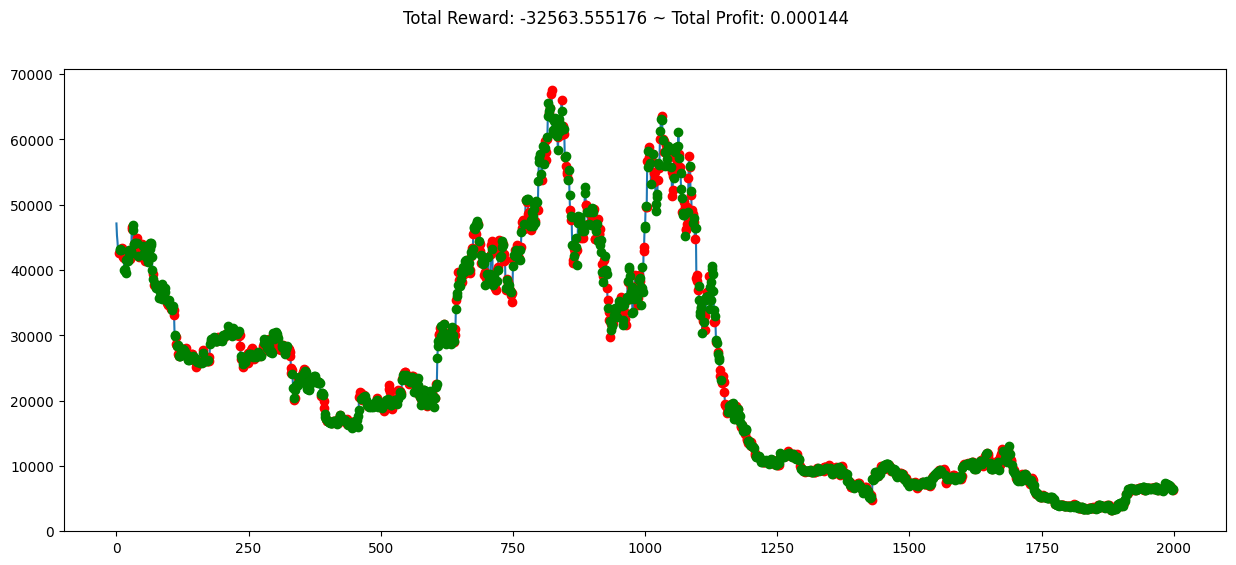

In [8]:
random_moves(env)

As you see, the starting position of the environment is always Short.
As you see, the first 5 points (window_size=5) on the plot don't have a position. Because they aren't involved
Window size is just how many starting points we want to skip, if set to 1000, we skip first 1000 points

## 3. Build environment and train

different algorithms from baselines package:
https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html


* training is performed from day 5 until day 2300

* frame bound need to start from at least window size

* Properties:

        frame_bound: A tuple which specifies the start and end of df. It is passed in the class' constructor.
        
        trade_fee_bid_percent: A default constant fee percentage for bids. For example with trade_fee_bid_percent=0.01, you will lose 1% of your money every time you sell your shares.
        
        trade_fee_ask_percent: A default constant fee percentage for asks. For example with trade_fee_ask_percent=0.005, you will lose 0.5% of your money every time you buy some shares.

In [9]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5, 2300), window_size=5)
env = DummyVecEnv([env_maker])

model = A2C('MlpPolicy', env, verbose=1) # https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html#a2c-policies
#'CnnPolicy' , 'MultiInputPolicy'

model.learn(total_timesteps=10)


Using cuda device


# 4. Evaluation - random steps example

In [10]:
def evaluate(env:gym.Env, model, verbose:bool = False)-> list:
    obs, info = env.reset(seed=2023)
    actions=[]
    while True:
        obs = obs[np.newaxis, :]
        action, _states = model.predict(obs)

        obs, rewards, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        actions.append(('Buy' if action==[1] else 'Sell',rewards))
        if done:
            print("info", info)
            break
    
    plt.figure(figsize=(15,6))
    plt.cla()
    env.unwrapped.render_all()
    plt.show()
    if verbose:
        print(("------------Debug info:----------------"))
        print("----------------------------------------Actions:----------------------------------------")
        print(actions)
    return info

Stock environment and similar like forex
https://github.com/AminHP/gym-anytrading

Gym documentation:
https://gymnasium.farama.org/content/basic_usage/

info {'total_reward': -204.679443359375, 'total_profit': 0.7888332975111384, 'position': <Positions.Short: 0>}


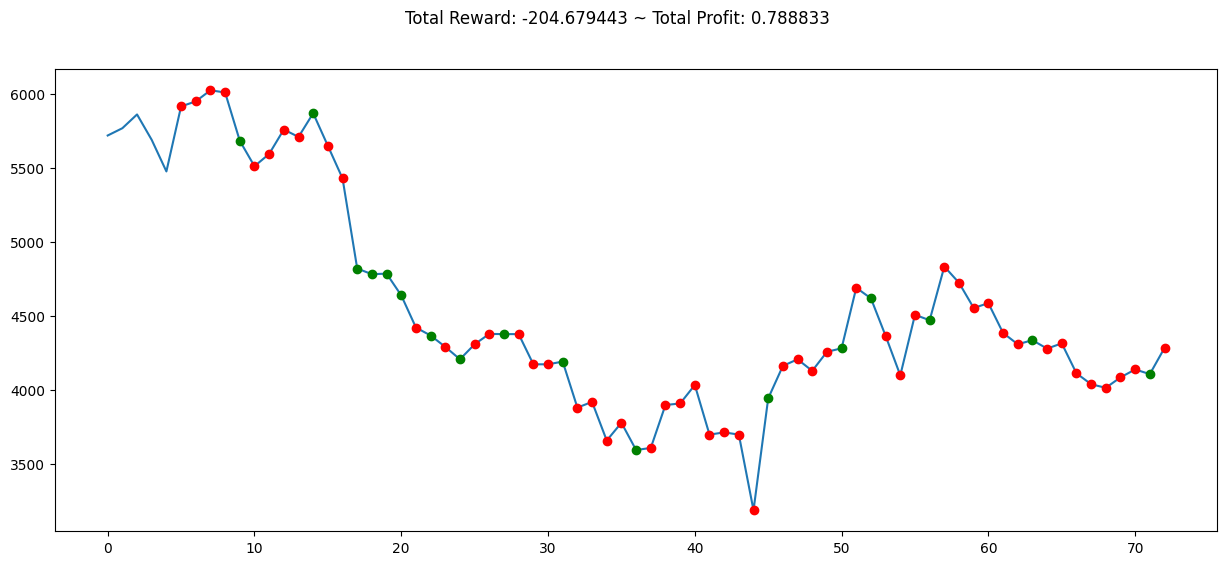

------------Debug info:----------------
----------------------------------------Actions:----------------------------------------
[('Sell', 0), ('Sell', 0), ('Sell', 0), ('Buy', 0), ('Sell', -171.83984375), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Buy', 0), ('Sell', -220.01025390625), ('Sell', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Sell', -398.43017578125), ('Buy', 0), ('Sell', -76.56982421875), ('Buy', 0), ('Sell', 101.41015625), ('Sell', 0), ('Buy', 0), ('Sell', 0.02978515625), ('Sell', 0), ('Sell', 0), ('Buy', 0), ('Sell', -310.64990234375), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Buy', 0), ('Sell', 14.119873046875), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Buy', 0), ('Sell', 219.0302734375), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Buy', 0), ('Sell', 408.81005859375), ('Buy', 0), ('Sell', -253.2998046875), ('Sell', 0), ('Sell', 0), ('Buy', 0), ('Sell', 362.77001953125), ('Sell', 0), ('Sell', 0), ('Sell', 0), ('Sell'

{'total_reward': -204.679443359375,
 'total_profit': 0.7888332975111384,
 'position': <Positions.Short: 0>}

In [11]:
# check different frame bound, best without overlap
env = gym.make('stocks-v0', df=df, frame_bound=(2300, 2500),window_size=5) #render_mode="human"
evaluate(env=env, model=model, verbose= True)

# Part 2. Technical indicators
https://www.youtube.com/watch?v=q-Uw9gC3D4o&t=343s

In [12]:
# need to change the sorting order to "from oldest to newest" order 
df.head()

Unix   Symbol      Open      High       Low     Close       Volume   Volume USDT  tradecount
Date                                                                                                             
2024-02-09  1707436800000  BTCUSDT  45288.66  48200.00  45242.12  47132.77  73503.48100  3.453043e+09     2323884
2024-02-08  1707350400000  BTCUSDT  44349.60  45614.30  44331.10  45288.65  45439.62231  2.042912e+09     1863650
2024-02-07  1707264000000  BTCUSDT  43098.96  44396.50  42788.00  44349.60  34392.59915  1.496014e+09     1378809
2024-02-06  1707177600000  BTCUSDT  42708.70  43399.98  42574.00  43098.95  24675.85433  1.061050e+09     1120760
2024-02-05  1707091200000  BTCUSDT  42582.88  43569.76  42258.10  42708.70  29467.75905  1.262621e+09     1317397

In [13]:
df_sorted=df.sort_values('Date', ascending=True)
df_sorted.head()

Unix   Symbol     Open     High      Low    Close       Volume   Volume USDT  tradecount
Date                                                                                                         
2017-08-17  1502928000000  BTCUSDT  4261.48  4485.39  4200.74  4285.08   795.150377  3.454770e+06        3427
2017-08-18  1503014400000  BTCUSDT  4285.08  4371.52  3938.77  4108.37  1199.888264  5.086958e+06        5233
2017-08-19  1503100800000  BTCUSDT  4108.37  4184.69  3850.00  4139.98   381.309763  1.549484e+06        2153
2017-08-20  1503187200000  BTCUSDT  4120.98  4211.08  4032.62  4086.29   467.083022  1.930364e+06        2321
2017-08-21  1503273600000  BTCUSDT  4069.13  4119.62  3911.79  4016.00   691.743060  2.797232e+06        3972

In [14]:
env = gym.make('stocks-v0', df=df_sorted, frame_bound=(500, 700),window_size=5)

In [15]:
env.unwrapped.signal_features

array([[ 3.745790e+03,  0.000000e+00],
       [ 3.777740e+03,  3.195000e+01],
       [ 3.567910e+03, -2.098300e+02],
       [ 3.839260e+03,  2.713500e+02],
       [ 3.695320e+03, -1.439400e+02],
       [ 3.801910e+03,  1.065900e+02],
       [ 3.702900e+03, -9.901000e+01],
       [ 3.797140e+03,  9.424000e+01],
       [ 3.858560e+03,  6.142000e+01],
       [ 3.766780e+03, -9.178000e+01],
       [ 3.792010e+03,  2.523000e+01],
       [ 3.770960e+03, -2.105000e+01],
       [ 3.987600e+03,  2.166400e+02],
       [ 3.975450e+03, -1.215000e+01],
       [ 3.955130e+03, -2.032000e+01],
       [ 3.966650e+03,  1.152000e+01],
       [ 3.585880e+03, -3.807700e+02],
       [ 3.601310e+03,  1.543000e+01],
       [ 3.583130e+03, -1.818000e+01],
       [ 3.476810e+03, -1.063200e+02],
       [ 3.626090e+03,  1.492800e+02],
       [ 3.553060e+03, -7.303000e+01],
       [ 3.591840e+03,  3.878000e+01],
       [ 3.616210e+03,  2.437000e+01],
       [ 3.594870e+03, -2.134000e+01],
       [ 3.665300e+03,  7

info {'total_reward': 4385.37060546875, 'total_profit': 0.9632671085142563, 'position': <Positions.Short: 0>}


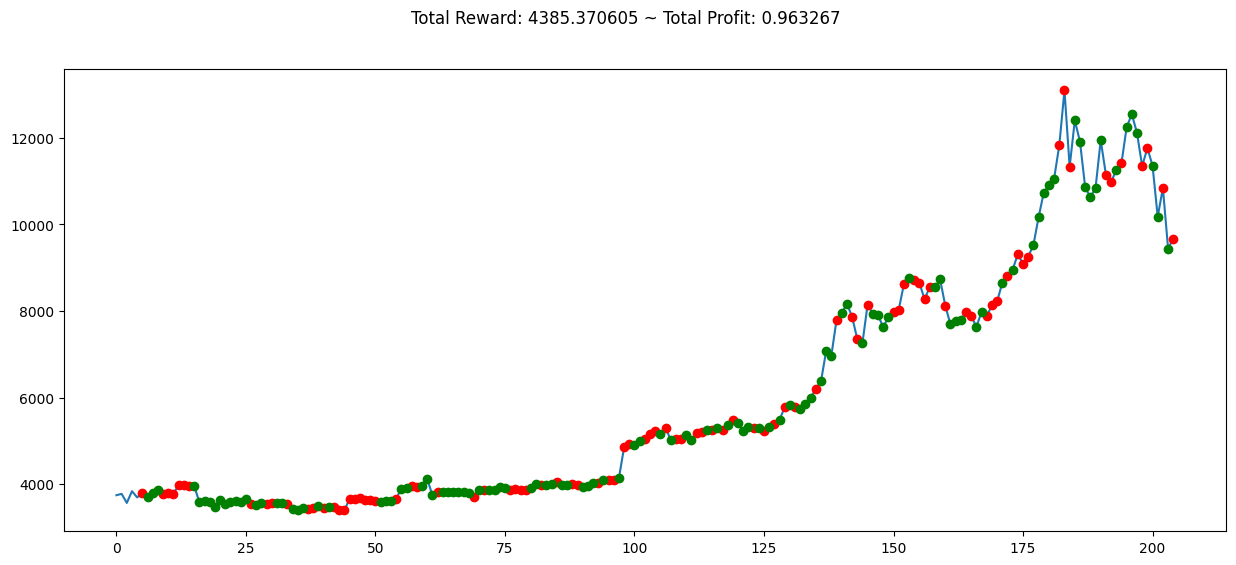

In [16]:
random_moves(env)

# 2.1 Data Indicators

In [17]:
from gym_anytrading.envs import StocksEnv
from finta import TA # https://github.com/peerchemist/fintahttps://github.com/peerchemist/finta

In [18]:
df_sorted.dtypes
# Volume column is string (23,333,333) not float (23333333)
# df_sorted['Volume'] = df['Volume'].apply(lambda x: float(x.replace(",","")))

Unix             int64
Symbol          object
Open           float64
High           float64
Low            float64
Close          float64
Volume         float64
Volume USDT    float64
tradecount       int64
dtype: object

In [19]:
df_sorted.head()

Unix   Symbol     Open     High      Low    Close       Volume   Volume USDT  tradecount
Date                                                                                                         
2017-08-17  1502928000000  BTCUSDT  4261.48  4485.39  4200.74  4285.08   795.150377  3.454770e+06        3427
2017-08-18  1503014400000  BTCUSDT  4285.08  4371.52  3938.77  4108.37  1199.888264  5.086958e+06        5233
2017-08-19  1503100800000  BTCUSDT  4108.37  4184.69  3850.00  4139.98   381.309763  1.549484e+06        2153
2017-08-20  1503187200000  BTCUSDT  4120.98  4211.08  4032.62  4086.29   467.083022  1.930364e+06        2321
2017-08-21  1503273600000  BTCUSDT  4069.13  4119.62  3911.79  4016.00   691.743060  2.797232e+06        3972

### SMA, RSI, OBV Indicators

In [20]:
df_sorted['SMA']= TA.SMA(df_sorted,12)
df_sorted['RSI']=TA.RSI(df_sorted)
df_sorted['OBV']=TA.OBV(df_sorted)
df_sorted.fillna(0, inplace=True)
df_sorted.head(25)

Unix   Symbol     Open     High      Low    Close       Volume   Volume USDT  tradecount          SMA        RSI          OBV
Date                                                                                                                                              
2017-08-17  1502928000000  BTCUSDT  4261.48  4485.39  4200.74  4285.08   795.150377  3.454770e+06        3427     0.000000   0.000000     0.000000
2017-08-18  1503014400000  BTCUSDT  4285.08  4371.52  3938.77  4108.37  1199.888264  5.086958e+06        5233     0.000000   0.000000 -1199.888264
2017-08-19  1503100800000  BTCUSDT  4108.37  4184.69  3850.00  4139.98   381.309763  1.549484e+06        2153     0.000000  16.152451  -818.578501
2017-08-20  1503187200000  BTCUSDT  4120.98  4211.08  4032.62  4086.29   467.083022  1.930364e+06        2321     0.000000  12.468550 -1285.661523
2017-08-21  1503273600000  BTCUSDT  4069.13  4119.62  3911.79  4016.00   691.743060  2.797232e+06        3972     0.000000   9.434761 -1977.404583
2017-08-22  1503360000000  BTCUSDT  4016.00  4104.82  3400.00  4040.00   966.684858  3.752506e+06        6494     0.000000  16.872115 -1010.719725
2017-08-23  1503446400000  BTCUSDT  4040.00  4265.80  4013.89  4114.01  1001.136565  4.148686e+06        8629     0.000000  34.684982    -9.583160
2017-08-24  1503532800000  BTCUSDT  4147.00  4371.68  4085.01  4316.01   787.418753  3.296476e+06        6247     0.000000  59.925592   777.835593
2017-08-25  1503619200000  BTCUSDT  4316.01  4453.91  4247.48  4280.68   573.612740  2.484637e+06        6554     0.000000  55.859643   204.222853
2017-08-26  1503705600000  BTCUSDT  4280.71  4367.00  4212.41  4337.44   228.108068  9.778657e+05        2260     0.000000  60.496929   432.330921
2017-08-27  1503792000000  BTCUSDT  4332.51  4400.00  4285.54  4310.01   350.692585  1.521580e+06        3670     0.000000  57.360681    81.638336
2017-08-28  1503878400000  BTCUSDT  4310.01  4399.82  4124.54  4386.69   603.841616  2.591661e+06        4349  4201.713333  63.116993   685.479952
2017-08-29  1503964800000  BTCUSDT  4353.65  4625.85  4313.55  4587.48   603.545028  2.682484e+06        4159  4226.913333  73.286664  1289.024980
2017-08-30  1504051200000  BTCUSDT  4564.52  4647.51  4416.01  4555.14   808.468771  3.683715e+06        5551  4264.144167  69.941642   480.556209
2017-08-31  1504137600000  BTCUSDT  4555.14  4745.42  4555.14  4724.89   556.956802  2.579879e+06        4161  4312.886667  76.106333  1037.513011
2017-09-01  1504224000000  BTCUSDT  4689.89  4885.55  4654.88  4834.91   560.666366  2.665166e+06        4000  4375.271667  79.098405  1598.179377
2017-09-02  1504310400000  BTCUSDT  4796.16  4939.19  4286.87  4472.14   929.148595  4.257724e+06        7475  4413.283333  54.752047   669.030782
2017-09-03  1504396800000  BTCUSDT  4508.50  4714.76  4298.33  4509.08   691.216198  3.121053e+06        6022  4452.373333  56.229448  1360.246980
2017-09-04  1504483200000  BTCUSDT  4505.00  4527.49  3972.51  4100.11  1394.644614  5.909947e+06        9317  4451.215000  40.473369   -34.397634
2017-09-05  1504569600000  BTCUSDT  4106.97  4484.99  3603.00  4366.47  1228.938157  5.083453e+06       10084  4455.420000  50.250949  1194.540523
2017-09-06  1504656000000  BTCUSDT  4366.49  4662.87  4335.26  4619.77   807.363726  3.626346e+06        7956  4483.677500  57.414561  2001.904249
2017-09-07  1504742400000  BTCUSDT  4619.77  4788.59  4438.19  4691.61   500.429975  2.305795e+06        3070  4513.191667  59.208599  2502.334224
2017-09-08  1504828800000  BTCUSDT  4691.66  4735.39  4028.93  4282.80  1132.255046  4.866527e+06        4733  4510.924167  47.059196  1370.079178
2017-09-09  1504915200000  BTCUSDT  4282.80  4426.62  4150.06  4258.81   658.782952  2.815383e+06        3777  4500.267500  46.456758   711.296226
2017-09-10  1505001600000  BTCUSDT  4258.81  4283.00  3801.00  4130.37   660.373275  2.700372e+06        3435  4462.175000  43.263429    50.922951

In [21]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['Low','Volume','SMA','RSI','OBV']].to_numpy()[start:end]
    return prices, signal_features

In [22]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

env2 = MyCustomEnv(df=df_sorted, window_size=12, frame_bound=(25,2300)) # training data from day 12  till 50

In [23]:
env2.prices  # prices matching the Low values

array([ 4416.01,  4555.14,  4654.88, ..., 37615.86, 38641.61, 39274.86])

In [24]:
df_sorted.head() # matching values

Unix   Symbol     Open     High      Low    Close       Volume   Volume USDT  tradecount  SMA        RSI          OBV
Date                                                                                                                                      
2017-08-17  1502928000000  BTCUSDT  4261.48  4485.39  4200.74  4285.08   795.150377  3.454770e+06        3427  0.0   0.000000     0.000000
2017-08-18  1503014400000  BTCUSDT  4285.08  4371.52  3938.77  4108.37  1199.888264  5.086958e+06        5233  0.0   0.000000 -1199.888264
2017-08-19  1503100800000  BTCUSDT  4108.37  4184.69  3850.00  4139.98   381.309763  1.549484e+06        2153  0.0  16.152451  -818.578501
2017-08-20  1503187200000  BTCUSDT  4120.98  4211.08  4032.62  4086.29   467.083022  1.930364e+06        2321  0.0  12.468550 -1285.661523
2017-08-21  1503273600000  BTCUSDT  4069.13  4119.62  3911.79  4016.00   691.743060  2.797232e+06        3972  0.0   9.434761 -1977.404583

In [25]:
env2.signal_features # are matching Low, Volume, SMA, RSI, OBV

array([[ 4.41601000e+03,  8.08468771e+02,  4.26414417e+03,
         6.99416420e+01,  4.80556209e+02],
       [ 4.55514000e+03,  5.56956802e+02,  4.31288667e+03,
         7.61063333e+01,  1.03751301e+03],
       [ 4.65488000e+03,  5.60666366e+02,  4.37527167e+03,
         7.90984053e+01,  1.59817938e+03],
       ...,
       [ 3.76158600e+04,  4.34156632e+04,  3.75131175e+04,
         6.51323645e+01, -1.29689290e+06],
       [ 3.86416100e+04,  2.66969216e+04,  3.76799150e+04,
         6.85813662e+01, -1.27019598e+06],
       [ 3.92748600e+04,  2.67106534e+04,  3.80324658e+04,
         7.07027215e+01, -1.24348533e+06]])

## 2.2 Build environment and train

In [26]:
env_maker= lambda: env2
env = DummyVecEnv([env_maker])

A2C is meant to be run primarily on the CPU, especially when you are not using a CNN. To improve CPU utilization, try turning off the GPU and using SubprocVecEnv instead of the default DummyVecEnv.
A2C.png      


<div>
<img src="../av_crypto_trading/docs/A2C.png" width="1500"/>
</div>

In [27]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10) #1000000

Using cuda device


info {'total_reward': 19704.599999999977, 'total_profit': 0.0012518032535421152, 'position': <Positions.Long: 1>}


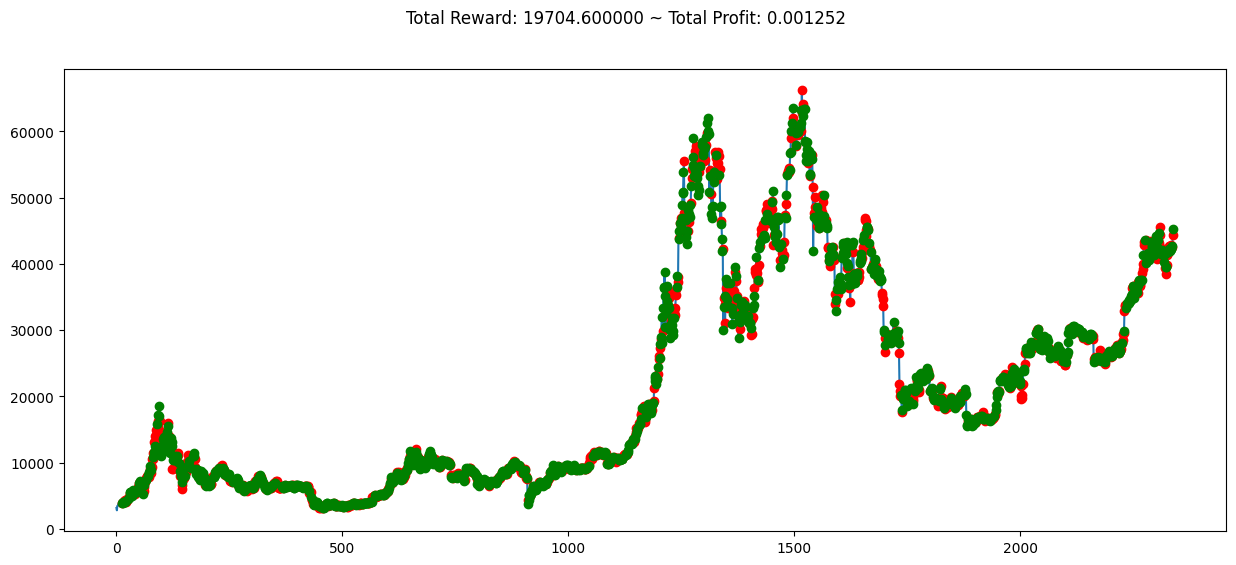

------------Debug info:----------------
----------------------------------------Actions:----------------------------------------
[('Buy', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Sell', 367.23), ('Sell', 0), ('Sell', 0), ('Buy', 0), ('Sell', -32.0), ('Buy', 0), ('Sell', 20.5600000000004), ('Sell', 0), ('Buy', 0), ('Sell', 130.59000000000015), ('Buy', 0), ('Sell', 100.15999999999985), ('Buy', 0), ('Buy', 0), ('Sell', 20.170000000000073), ('Buy', 0), ('Sell', -76.55999999999949), ('Buy', 0), ('Sell', 452.3100000000004), ('Sell', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Sell', -400.02999999999975), ('Sell', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Buy', 0), ('Sell', 380.0), ('Buy', 0), ('Sell', 238.02000000000044), ('Sell', 0), ('Sell', 0), ('Buy', 0), ('Buy', 0), ('Sell', 5.0), ('Buy', 0), ('Sell', -250.0), ('Buy', 0), ('Sell', -759.9899999999998), ('Sell', 0), ('Buy', 0), ('Sell', 374.97999999999956), ('Sell', 0), ('Buy', 0), ('Sell', 500.0100000000002), ('Sell', 0), ('Buy', 0), ('Se

{'total_reward': 19704.599999999977,
 'total_profit': 0.0012518032535421152,
 'position': <Positions.Long: 1>}

In [28]:
env=MyCustomEnv(df=df_sorted, window_size=12, frame_bound=(40,2500)) 
evaluate(env, model, verbose=True)

# ML flow experiments tracker

In [29]:
import sys
from typing import Any, Dict, Tuple, Union

import mlflow
import numpy as np

from stable_baselines3 import SAC
from stable_baselines3.common.logger import HumanOutputFormat, KVWriter, Logger


class MLflowOutputFormat(KVWriter):
    """
    Dumps key/value pairs into MLflow's numeric format.
    """

    def write(
        self,
        key_values: Dict[str, Any],
        key_excluded: Dict[str, Union[str, Tuple[str, ...]]],
        step: int = 0,
    ) -> None:

        for (key, value), (_, excluded) in zip(
            sorted(key_values.items()), sorted(key_excluded.items())
        ):

            if excluded is not None and "mlflow" in excluded:
                continue

            if isinstance(value, np.ScalarType):
                if not isinstance(value, str):
                    mlflow.log_metric(key, value, step)


loggers = Logger(
    folder=None,
    output_formats=[HumanOutputFormat(sys.stdout), MLflowOutputFormat()],
)



In [30]:
with mlflow.start_run():
    # model = SAC("MlpPolicy", "Pendulum-v1", verbose=2)
    model = A2C('MlpPolicy', env, verbose=2)    
    
    # Set custom logger
    model.set_logger(loggers)
    
    # model.learn(total_timesteps=1000000, log_interval=1)
    model.learn(total_timesteps=10)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


To run mlflow ui in terminal: ```mlflow ui``` 
In examples directory!

In [31]:
#!mlflow ui

### Saving and loading the model

In [32]:
#model.save("mlruns/models/model_RL_BTC")

In [33]:
#del model

In [34]:
#model = A2C.load("mlruns/models/model_RL_BTC", env=env)

info {'total_reward': 8226.799999999985, 'total_profit': 0.6747231678365953, 'position': <Positions.Long: 1>}


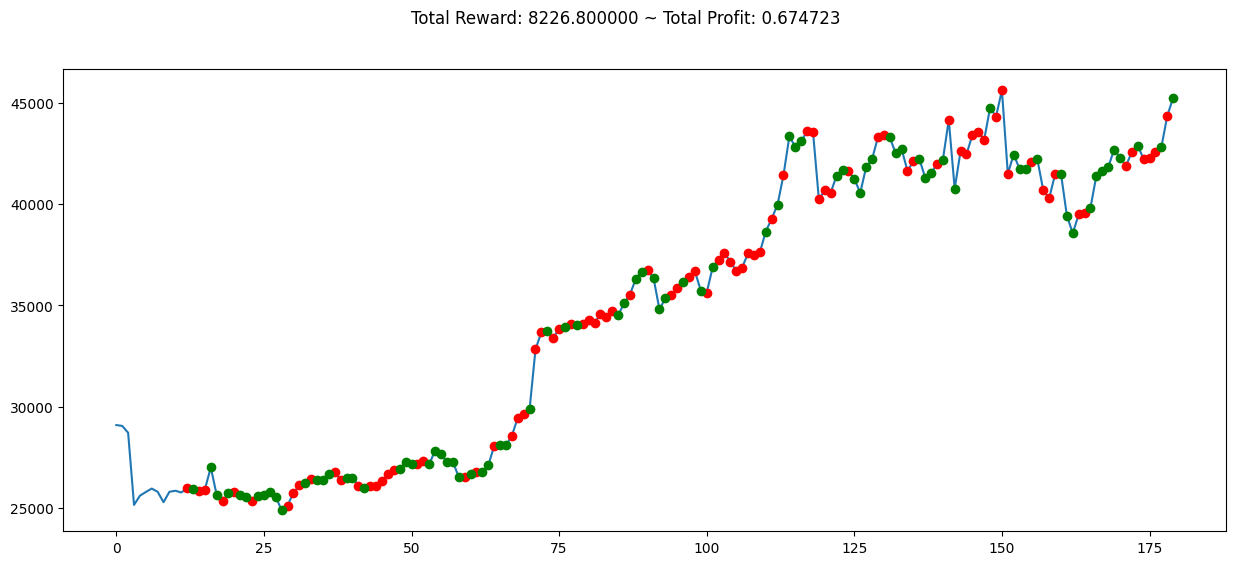

{'total_reward': 8226.799999999985,
 'total_profit': 0.6747231678365953,
 'position': <Positions.Long: 1>}

In [35]:
env=MyCustomEnv(df=df_sorted, window_size=12, frame_bound=(2200,2900)) 
evaluate(env, model)

# Experimental saving session of notebook

In [36]:
#!pip install dill
# import dill
# dill.dump_module('notebook_env.db')

In [37]:
# import dill
# dill.load_session('notebook_env.db')

# Part 3. Smart Money Concept
literature: <a href="https://pl.tradingview.com/script/CnB3fSph-Smart-Money-Concepts-LuxAlgo/"> https://pl.tradingview.com/script/CnB3fSph-Smart-Money-Concepts-LuxAlgo/ </a>
repository: <a href="https://github.com/joshyattridge/smartmoneyconcepts/tree/master"> https://github.com/joshyattridge/smartmoneyconcepts/tree/master</a>

In [46]:
# package need to be added via  pycharm env
from smartmoneyconcepts import smc


In [86]:
df_smc= df_sorted.reset_index()
#df_smc=df_smc.drop('FVG',axis=1)

In [87]:
df_smc.head()

Date           Unix   Symbol     Open     High      Low    Close       Volume   Volume USDT  tradecount  SMA        RSI          OBV  FVG
0 2017-08-17  1502928000000  BTCUSDT  4261.48  4485.39  4200.74  4285.08   795.150377  3.454770e+06        3427  0.0   0.000000     0.000000  NaN
1 2017-08-18  1503014400000  BTCUSDT  4285.08  4371.52  3938.77  4108.37  1199.888264  5.086958e+06        5233  0.0   0.000000 -1199.888264  NaN
2 2017-08-19  1503100800000  BTCUSDT  4108.37  4184.69  3850.00  4139.98   381.309763  1.549484e+06        2153  0.0  16.152451  -818.578501  NaN
3 2017-08-20  1503187200000  BTCUSDT  4120.98  4211.08  4032.62  4086.29   467.083022  1.930364e+06        2321  0.0  12.468550 -1285.661523  NaN
4 2017-08-21  1503273600000  BTCUSDT  4069.13  4119.62  3911.79  4016.00   691.743060  2.797232e+06        3972  0.0   9.434761 -1977.404583  NaN

 ```PY
    smc.fvg(ohlc) # Fair Value Gap
    smc.highs_lows(ohlc) # Highs and Lows
    smc.swing_tops_bottoms(ohlc, swing_length=10) # Swing Tops and Bottoms
    smc.bos_choch(ohlc, close_break=True, filter_liquidity=False) # Detect BOS and CHoCH
    smc.ob(ohlc) # Order Block
    smc.vob(ohlc) # Volumized Order Blocks
    smc.liquidity(ohlc) # Liquidity
```

In [88]:
df_smc= pd.merge(df_smc,smc.fvg(df_sorted), left_index=True, right_index=True)
df_smc= pd.merge(df_smc,smc.highs_lows(df_sorted), left_index=True, right_index=True)
df_smc= pd.merge(df_smc,smc.swing_tops_bottoms(df_sorted, swing_length=10), left_index=True, right_index=True)
df_smc= pd.merge(df_smc,smc.bos_choch(df_sorted, close_break=True, filter_liquidity=False), left_index=True, right_index=True)
df_smc= pd.merge(df_smc,smc.ob(df_sorted), left_index=True, right_index=True)
# df_smc= pd.merge(df_smc,smc.vob(df_sorted), left_index=True, right_index=True)
df_smc= pd.merge(df_smc,smc.liquidity(df_sorted), left_index=True, right_index=True)
df_smc.set_index('Date', inplace=True)
df_smc

Date           Unix   Symbol      Open      High       Low     Close         Volume   Volume USDT  tradecount           SMA        RSI           OBV  FVG_x  FVG_y     Top_x  Bottom_x  MitigatedIndex_x  HighsLows  Levels_x  SwingTopsBottoms  Levels_y  BOS  CHOCH       Level_x  BrokenIndex   OB     Top_y  \
0    2017-08-17  1502928000000  BTCUSDT   4261.48   4485.39   4200.74   4285.08     795.150377  3.454770e+06        3427      0.000000   0.000000  0.000000e+00    NaN      0   3938.77       NaN                 0          1   4485.39                 0       NaN    0      0      0.000000            0 -1.0   4485.39   
1    2017-08-18  1503014400000  BTCUSDT   4285.08   4371.52   3938.77   4108.37    1199.888264  5.086958e+06        5233      0.000000   0.000000 -1.199888e+03    NaN     -1   4200.74   4184.69                 3          0       NaN                 0       NaN    0      0      0.000000            0  0.0   4371.52   
2    2017-08-19  1503100800000  BTCUSDT   4108.37   4184.69   3850.00   4139.98     381.309763  1.549484e+06        2153      0.000000  16.152451 -8.185785e+02    NaN      0   4032.62   4371.52                 0          0       NaN                 0       NaN    0      0      0.000000            0  0.0   4184.69   
3    2017-08-20  1503187200000  BTCUSDT   4120.98   4211.08   4032.62   4086.29     467.083022  1.930364e+06        2321      0.000000  12.468550 -1.285662e+03    NaN      0   3850.00   4119.62                 0          0       NaN                 0       NaN    0      0      0.000000            0  0.0   4211.08   
4    2017-08-21  1503273600000  BTCUSDT   4069.13   4119.62   3911.79   4016.00     691.743060  2.797232e+06        3972      0.000000   9.434761 -1.977405e+03    NaN      0   4032.62   4104.82                 0          0       NaN                 0       NaN    0      0      0.000000            0  0.0   4119.62   
5    2017-08-22  1503360000000  BTCUSDT   4016.00   4104.82   3400.00   4040.00     966.684858  3.752506e+06        6494      0.000000  16.872115 -1.010720e+03    NaN      0   4013.89   4119.62                 0         -1   3400.00                -1   3400.00    0      0      0.000000            0  0.0   4104.82   
6    2017-08-23  1503446400000  BTCUSDT   4040.00   4265.80   4013.89   4114.01    1001.136565  4.148686e+06        8629      0.000000  34.684982 -9.583160e+00    NaN      0   4085.01   4104.82                 0          0       NaN                 0       NaN    0      0      0.000000            0  0.0   4265.80   
7    2017-08-24  1503532800000  BTCUSDT   4147.00   4371.68   4085.01   4316.01     787.418753  3.296476e+06        6247      0.000000  59.925592  7.778356e+02    NaN      0   4247.48   4265.80                 0          0       NaN                 0       NaN    0      0      0.000000            0  0.0   4371.68   
8    2017-08-25  1503619200000  BTCUSDT   4316.01   4453.91   4247.48   4280.68     573.612740  2.484637e+06        6554      0.000000  55.859643  2.042229e+02    NaN      0   4085.01   4367.00                 0          0       NaN                 0       NaN    0      0      0.000000            0  0.0   4453.91   
9    2017-08-26  1503705600000  BTCUSDT   4280.71   4367.00   4212.41   4337.44     228.108068  9.778657e+05        2260      0.000000  60.496929  4.323309e+02    NaN      0   4285.54   4453.91                 0          0       NaN                 0       NaN    0      0      0.000000            0  0.0   4367.00   
10   2017-08-27  1503792000000  BTCUSDT   4332.51   4400.00   4285.54   4310.01     350.692585  1.521580e+06        3670      0.000000  57.360681  8.163834e+01    NaN      0   4212.41   4399.82                 0          0       NaN                 0       NaN    0      0      0.000000            0  0.0   4400.00   
11   2017-08-28  1503878400000  BTCUSDT   4310.01   4399.82   4124.54   4386.69     603.841616  2.591661e+06        4349   4201.713333  63.116993  6.854800e+02    NaN      0   4313.55   4400.00  

In [93]:
df_smc.fillna(0, inplace=True)

In [94]:
df_smc

Unix   Symbol      Open      High       Low     Close         Volume   Volume USDT  tradecount           SMA        RSI           OBV  FVG_x  FVG_y     Top_x  Bottom_x  MitigatedIndex_x  HighsLows  Levels_x  SwingTopsBottoms  Levels_y  BOS  CHOCH       Level_x  BrokenIndex   OB     Top_y  \
Date                                                                                                                                                                                                                                                                                                                    
2017-08-17  1502928000000  BTCUSDT   4261.48   4485.39   4200.74   4285.08     795.150377  3.454770e+06        3427      0.000000   0.000000  0.000000e+00    0.0      0   3938.77      0.00                 0          1   4485.39                 0      0.00    0      0      0.000000            0 -1.0   4485.39   
2017-08-18  1503014400000  BTCUSDT   4285.08   4371.52   3938.77   4108.37    1199.888264  5.086958e+06        5233      0.000000   0.000000 -1.199888e+03    0.0     -1   4200.74   4184.69                 3          0      0.00                 0      0.00    0      0      0.000000            0  0.0   4371.52   
2017-08-19  1503100800000  BTCUSDT   4108.37   4184.69   3850.00   4139.98     381.309763  1.549484e+06        2153      0.000000  16.152451 -8.185785e+02    0.0      0   4032.62   4371.52                 0          0      0.00                 0      0.00    0      0      0.000000            0  0.0   4184.69   
2017-08-20  1503187200000  BTCUSDT   4120.98   4211.08   4032.62   4086.29     467.083022  1.930364e+06        2321      0.000000  12.468550 -1.285662e+03    0.0      0   3850.00   4119.62                 0          0      0.00                 0      0.00    0      0      0.000000            0  0.0   4211.08   
2017-08-21  1503273600000  BTCUSDT   4069.13   4119.62   3911.79   4016.00     691.743060  2.797232e+06        3972      0.000000   9.434761 -1.977405e+03    0.0      0   4032.62   4104.82                 0          0      0.00                 0      0.00    0      0      0.000000            0  0.0   4119.62   
2017-08-22  1503360000000  BTCUSDT   4016.00   4104.82   3400.00   4040.00     966.684858  3.752506e+06        6494      0.000000  16.872115 -1.010720e+03    0.0      0   4013.89   4119.62                 0         -1   3400.00                -1   3400.00    0      0      0.000000            0  0.0   4104.82   
2017-08-23  1503446400000  BTCUSDT   4040.00   4265.80   4013.89   4114.01    1001.136565  4.148686e+06        8629      0.000000  34.684982 -9.583160e+00    0.0      0   4085.01   4104.82                 0          0      0.00                 0      0.00    0      0      0.000000            0  0.0   4265.80   
2017-08-24  1503532800000  BTCUSDT   4147.00   4371.68   4085.01   4316.01     787.418753  3.296476e+06        6247      0.000000  59.925592  7.778356e+02    0.0      0   4247.48   4265.80                 0          0      0.00                 0      0.00    0      0      0.000000            0  0.0   4371.68   
2017-08-25  1503619200000  BTCUSDT   4316.01   4453.91   4247.48   4280.68     573.612740  2.484637e+06        6554      0.000000  55.859643  2.042229e+02    0.0      0   4085.01   4367.00                 0          0      0.00                 0      0.00    0      0      0.000000            0  0.0   4453.91   
2017-08-26  1503705600000  BTCUSDT   4280.71   4367.00   4212.41   4337.44     228.108068  9.778657e+05        2260      0.000000  60.496929  4.323309e+02    0.0      0   4285.54   4453.91                 0          0      0.00                 0      0.00    0      0      0.000000            0  0.0   4367.00   
2017-08-27  1503792000000  BTCUSDT   4332.51   4400.00   4285.54   4310.01     350.692585  1.521580e+06        3670      0.000000  57.360681  8.163834e+01    0.0      0   4212.41   4399.82                 0          0      0.00                 0      0.00    0     

In [97]:
def add_signals_smc(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['Low','Volume','FVG_x','FVG_y',
                                    'Top_x','Bottom_x', 'MitigatedIndex_x',
                                    'HighsLows', 'Levels_x', 'SwingTopsBottoms',
                                    'Levels_y', 'BOS', 'CHOCH', 'Level_x', 'BrokenIndex',
                                    'OB', 'Top_y', 'Bottom_y', 'MitigatedIndex_y',
                                    'Level_y', 'End', 'Swept']].to_numpy()[start:end]
    return prices, signal_features

In [98]:
class MyCustomEnvSMC(StocksEnv):
    _process_data = add_signals_smc

env_smc = MyCustomEnvSMC(df=df_smc, window_size=12, frame_bound=(25,2300))

In [99]:
env_smc.signal_features

array([[ 4416.01    ,   808.468771,     0.      , ...,     0.      ,
            0.      ,     0.      ],
       [ 4555.14    ,   556.956802,     0.      , ...,     0.      ,
            0.      ,     0.      ],
       [ 4654.88    ,   560.666366,     0.      , ...,     0.      ,
            0.      ,     0.      ],
       ...,
       [37615.86    , 43415.66324 ,     0.      , ...,     0.      ,
            0.      ,     0.      ],
       [38641.61    , 26696.92161 ,     0.      , ...,     0.      ,
            0.      ,     0.      ],
       [39274.86    , 26710.65335 ,     0.      , ...,     0.      ,
            0.      ,     0.      ]])

In [109]:
env_maker_smc= lambda: env_smc
env = DummyVecEnv([env_maker_smc])

In [103]:
with mlflow.start_run():
    model = A2C('MlpPolicy', env, verbose=2)    
    
    # Set custom logger
    model.set_logger(loggers)
    
    # model.learn(total_timesteps=1000000, log_interval=1)
    model.learn(total_timesteps=100000)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 897      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.654   |
|    explained_variance | -0.0157  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.175   |
|    value_loss         | 344      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 898      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.564   |
|    explained_variance | 6.6e-05  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 30.9     |
|    value_loss     

info {'total_reward': -4712.759999999999, 'total_profit': 0.4361767163976423, 'position': <Positions.Long: 1>}


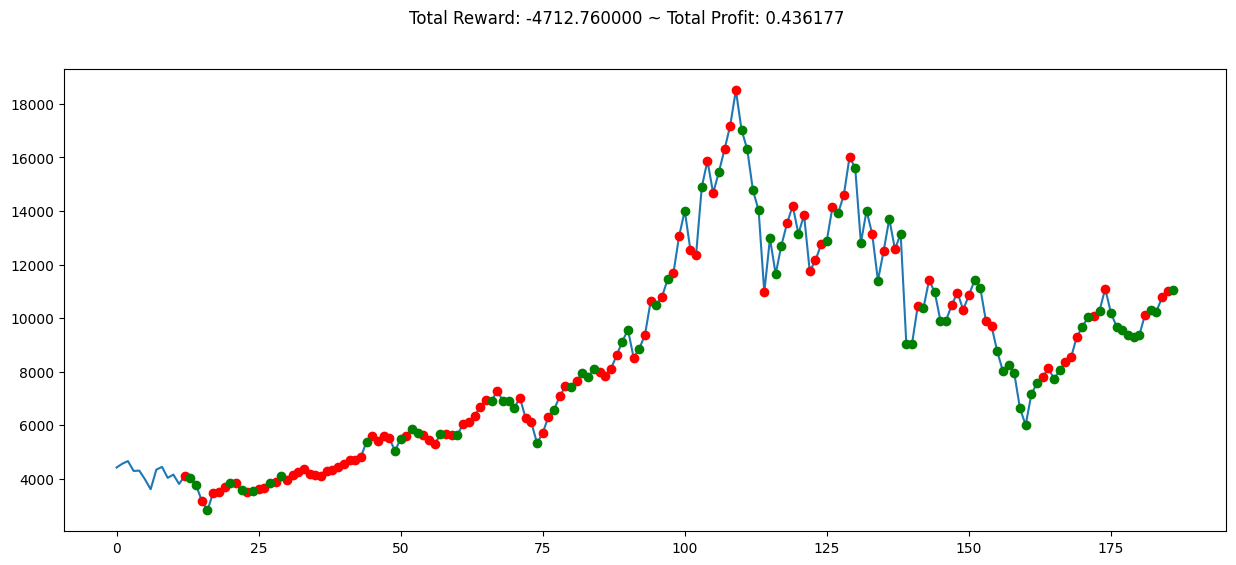

{'total_reward': -4712.759999999999,
 'total_profit': 0.4361767163976423,
 'position': <Positions.Long: 1>}

In [117]:
env_smc = MyCustomEnvSMC(df=df_smc, window_size=12, frame_bound=(25,200))
evaluate(env_smc, model)

In [113]:
# model.save("mlruns/models/model_RL_SMC_100k")

# Model should be able to wait a couple of days before deciding about the sell or buy

# Think about feature importance measure and normalization, regularization 